In [1]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import copy

In [2]:
#!unzip -o '/content/Assignment4data.zip'

Archive:  /content/Assignment4data.zip
 extracting: Assignment4data/README.txt  
 extracting: Assignment4data/test_X.npy  
 extracting: Assignment4data/test_y.npy  
 extracting: Assignment4data/train_X.npy  
 extracting: Assignment4data/train_y.npy  


In [3]:
X_train = np.load('Assignment4data/train_X.npy', allow_pickle=True)
y_train = np.load('Assignment4data/train_y.npy', allow_pickle=True)
X_test = np.load('Assignment4data/test_X.npy', allow_pickle=True)
y_test = np.load('Assignment4data/test_y.npy', allow_pickle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 28*28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).view(-1, 28*28)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 28*28)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_val_tensor, y_val_tensor)


In [4]:
batch_sizes = list(range(16, 1025))
#batch_sizes = [1,4]
activation_functions = ['relu', 'sigmoid', 'tanh']

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes, genome):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

        if genome['activation_function'] == 'relu':
            self.activation = nn.ReLU()
        elif genome['activation_function'] == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif genome['activation_function'] == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class Organism:
    def __init__(self):

        self.genome = {'batch_size': np.random.choice(batch_sizes),'activation_function': np.random.choice(activation_functions)}

        self.brain = NeuralNet(28*28, 10, self.genome)

        self.fitness = 0
        self.age = 0
        self.mutation_rate = 0.01

        self.learning_rate = 1e-4

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.brain.parameters(), lr=self.learning_rate)

    def train(self, train_dataset, num_epochs):

        self.brain = NeuralNet(28*28, 10, self.genome)
        self.optimizer = torch.optim.Adam(self.brain.parameters(), lr=self.learning_rate)

        self.num_epochs = num_epochs
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=int(self.genome['batch_size']), shuffle=True)
        self.brain.train()

        self.f1_log = []

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            self.y_true = []
            self.y_pred = []
            for inputs, targets in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.brain(inputs)
                self.outputs = outputs
                predicted = torch.argmax(outputs,1)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                self.y_true.append(targets.cpu().numpy())
                self.y_pred.append(predicted.cpu().numpy())

            self.y_pred = [item for sublist in self.y_pred for item in sublist]
            self.y_true = [item for sublist in self.y_true for item in sublist]
            f1 = f1_score(self.y_true, self.y_pred, average='macro')

            average_loss = running_loss / len(train_dataset)
            self.f1_log.append(f1)

    def evaluate_fitness(self, val_dataset):
        self.brain.eval()
        y_true = []
        y_pred = []
        for inputs, targets in val_dataset:
            outputs = self.brain(inputs)
            predicted = torch.argmax(outputs)
            y_true.append(targets.cpu().numpy())
            y_pred.append(predicted.cpu().numpy())

        f1 = f1_score(y_true, y_pred, average='macro')
        return f1

    def mutate(self):
        for i in range(len(self.genome)):
            if random.random() < self.mutation_rate:
                self.genome['batch_size'] = np.random.choice(batch_sizes)
            if random.random() < self.mutation_rate:
                self.genome['activation_function'] = np.random.choice(activation_functions)

In [7]:
pop_size = 10
num_parents = 4
num_gen = 100

In [8]:
def one_point_crossover(parent1, parent2):
    child1, child2 =  copy.copy(parent1), copy.copy(parent2)
    crossover_point = random.randint(1, len(parent1.brain.fc1.weight) - 1)
    child1.brain.fc1.weight.data[:crossover_point], child2.brain.fc1.weight.data[:crossover_point] = \
        parent2.brain.fc1.weight.data[:crossover_point], parent1.brain.fc1.weight.data[:crossover_point]
    return child1, child2

In [9]:
population = [Organism() for _ in range(pop_size)]
max_fitness = []
avg_fitness = []

for generation in range(num_gen):
    fitness_scores = []
    for organism in population:
        organism.train(train_dataset, 1)
        fitness_scores.append(organism.evaluate_fitness(val_dataset))


    total_fitness = sum(fitness_scores)
    selection_probabilities = [organism / total_fitness for organism in fitness_scores]
    selected_indices = random.choices(range(pop_size), weights=selection_probabilities, k=pop_size)

    new_population = []
    for _ in range(0, pop_size, 2):
        parent1 = population[selected_indices.pop()]
        parent2 = population[selected_indices.pop()]

        child1, child2 = one_point_crossover(parent1, parent2)

        child1.mutate()
        child2.mutate()

        new_population.extend([child1, child2])

    print(f"Generation {generation}: Best Fitness - {max(fitness_scores)}")
    max_fitness.append(max(fitness_scores))
    avg_fitness.append(np.mean(fitness_scores))
    population = new_population



Generation 0: Best Fitness - 0.2221998616790614
Generation 1: Best Fitness - 0.15507351868503266
Generation 2: Best Fitness - 0.2960990300083017
Generation 3: Best Fitness - 0.31067287378906994
Generation 4: Best Fitness - 0.38903546384932086
Generation 5: Best Fitness - 0.24706302045777542
Generation 6: Best Fitness - 0.2969817591566836
Generation 7: Best Fitness - 0.22531741867608615
Generation 8: Best Fitness - 0.22282311540322905
Generation 9: Best Fitness - 0.1051569107086098
Generation 10: Best Fitness - 0.08084393228223585
Generation 11: Best Fitness - 0.14663839480445093
Generation 12: Best Fitness - 0.1483618119910561
Generation 13: Best Fitness - 0.09314577994050843
Generation 14: Best Fitness - 0.10981915255068517
Generation 15: Best Fitness - 0.06190282058426992
Generation 16: Best Fitness - 0.10788356016430187
Generation 17: Best Fitness - 0.083651800418023
Generation 18: Best Fitness - 0.1587449588703414
Generation 19: Best Fitness - 0.10980574398138525
Generation 20: Bes

In [10]:
print(f"Best Genome: {population[np.argmax(fitness_scores)].genome}")

Best Genome: {'batch_size': 713, 'activation_function': 'relu'}


In [11]:
champion = population[np.argmax(fitness_scores)]
champion.brain = NeuralNet(28*28, 10, champion.genome)
champion.optimizer = torch.optim.Adam(champion.brain.parameters(), lr=champion.learning_rate)

champion.train(train_dataset,50)
champion.evaluate_fitness(test_dataset)

0.7188007512350929

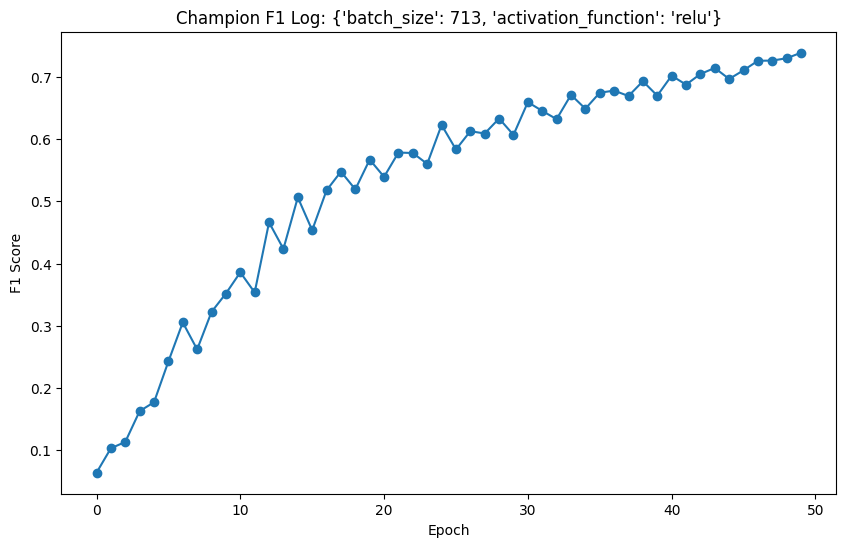

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(champion.f1_log, marker='o')

plt.title(f'Champion F1 Log: {champion.genome}')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.savefig('genetic_f1_log.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

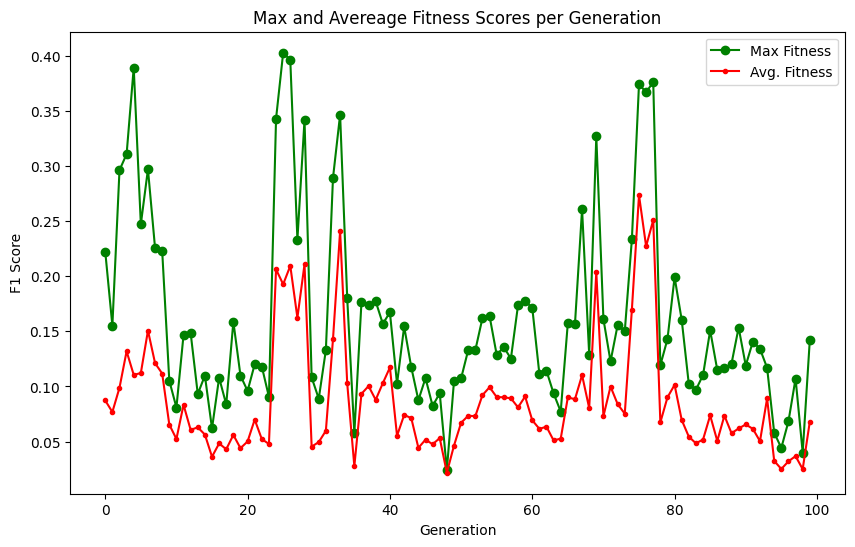

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(max_fitness, marker='o', color='green', label='Max Fitness')
plt.plot(avg_fitness, marker='.', color='red', label='Avg. Fitness')

plt.title(f'Max and Avereage Fitness Scores per Generation')
plt.xlabel('Generation')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('genetic_fitness.png', dpi=300, format='png', bbox_inches='tight')

plt.show()